In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')
#from skimage.measure import label, regionprops

In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from scipy.stats import skew, kurtosis

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

In [4]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = s.time[-1]
t_init = t_final - 1

dens = s.get_field('n', t1=t_init, t2=t_final)
#tempe = s.get_field('temperature', t1=t_init, t2=t_final)
#pe = dens * tempe
#tempi = s.get_field('temperaturi', t1=t_init, t2=t_final)
strmf = s.get_field('strmf', t1=t_init, t2=t_final)
#omega = s.get_field('omega', t1=t_init, t2=t_final)
#vpari = s.get_field('vpari', t1=t_init, t2=t_final)
#vpare = s.get_field('vpari', t1=t_init, t2=t_final)

# Density
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_std  = np.std(dens, axis=(2,3))
dens_avg_tor = np.mean(dens, axis=2)

# Normalized
dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)

# Density
strmf_avg  = np.mean(strmf, axis=(2,3)); 
strmf_std  = np.std(strmf, axis=(2,3))
strmf_avg_tor = np.mean(strmf, axis=2)

# Normalized
strmf_fluct   = np.sqrt((strmf[:,:,0,:]-strmf_avg_tor)**2) / strmf_avg_tor
#strmf_fluct = strmf[:,:,0,-1] - strmf_avg
strmf_fluct_avg = np.mean(strmf_fluct, axis=2)


#tempe_avg = np.mean(tempe, axis=(2,3))
#pe_avg    = np.mean(pe, axis=(2,3))
#tempi_avg = np.mean(tempi, axis=(2,3))
#strmf_avg = np.mean(strmf, axis=(2,3))
#omega_avg = np.mean(omega, axis=(2,3))
#vpari_avg = np.mean(vpari, axis=(2,3))
#vpare_avg = np.mean(vpare, axis=(2,3))

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi
Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

# Analysis

In [6]:
# dens, strmf: (ny, nx, nphi, nt)
ny, nx, nphi, nt = dens.shape

# Toroidal average → keep time dependence
dens_t   = dens.mean(axis=2)   # (ny, nx, nt)
strmf_t  = strmf.mean(axis=2)  # (ny, nx, nt)

# Time array and dt
t_arr = s.time                # shape (nt,)
dt    = float(t_arr[1] - t_arr[0])


In [7]:
# Same positions as in your 2D plot
R_points = np.array([
    s.x0 - 130,
    s.x0 - 200,
    s.x0 + 130,
    s.x0 + 200,
    s.x0 + 250,
], dtype=float)

Z_points = np.full_like(R_points, s.y0, dtype=float)

ix_list = [np.argmin(np.abs(s.x - R)) for R in R_points]
iy_list = [np.argmin(np.abs(s.y - Z)) for Z in Z_points]

print("Grid indices for points (iy, ix):")
for k, (iy, ix) in enumerate(zip(iy_list, ix_list), start=1):
    print(f"  P{k}: R={R_points[k-1]:.1f}, Z={Z_points[k-1]:.1f} -> (iy={iy}, ix={ix})")


Grid indices for points (iy, ix):
  P1: R=168.8, Z=483.8 -> (iy=195, ix=69)
  P2: R=98.8, Z=483.8 -> (iy=195, ix=41)
  P3: R=428.8, Z=483.8 -> (iy=195, ix=173)
  P4: R=498.8, Z=483.8 -> (iy=195, ix=201)
  P5: R=548.8, Z=483.8 -> (iy=195, ix=221)


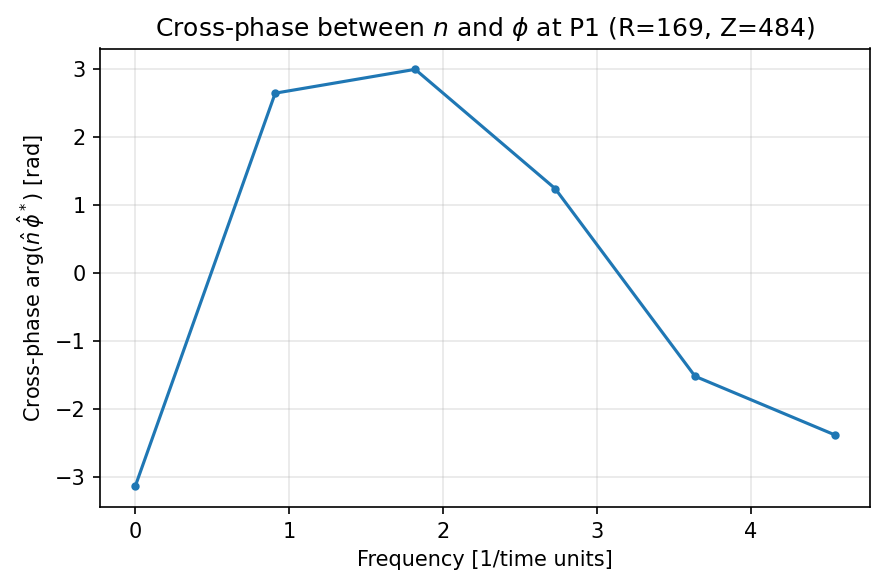

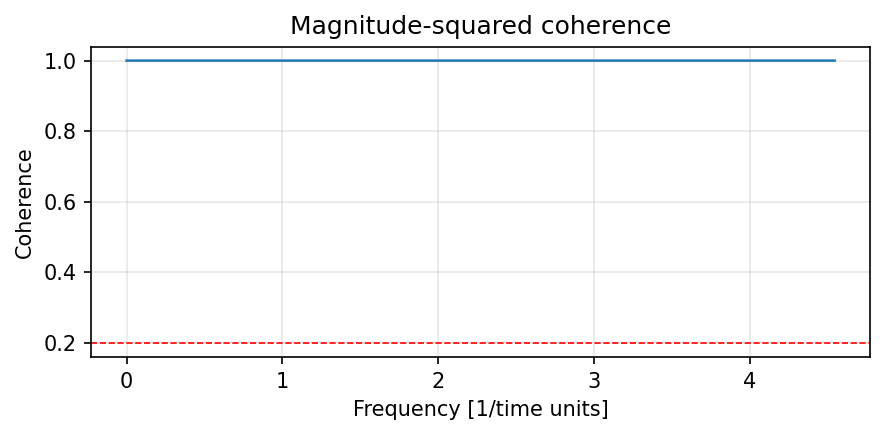

In [8]:
import matplotlib.pyplot as plt

# Pick point index (0..len(ix_list)-1)
k0 = 0
iy0, ix0 = iy_list[k0], ix_list[k0]

# Time series at that point
n_ts   = dens_t[iy0, ix0, :]    # density(t)
phi_ts = strmf_t[iy0, ix0, :]   # potential(t)

freq, phase, coh = cross_phase_time_series(n_ts, phi_ts, dt)

# Optional: only keep frequencies with decent coherence
coh_threshold = 0.2
mask = coh > coh_threshold

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=150)

ax1.plot(freq[mask], phase[mask], 'o-', ms=3)
ax1.set_xlabel('Frequency [1/time units]')
ax1.set_ylabel('Cross-phase arg($\hat{n}\,\hat{\phi}^*$) [rad]')
ax1.set_title(
    fr'Cross-phase between $n$ and $\phi$ at P{k0+1} '
    fr'(R={R_points[k0]:.0f}, Z={Z_points[k0]:.0f})'
)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# If you also want to inspect coherence:
fig, ax2 = plt.subplots(figsize=(6, 3), dpi=150)
ax2.plot(freq, coh, '-', lw=1.2)
ax2.axhline(coh_threshold, color='r', ls='--', lw=0.8)
ax2.set_xlabel('Frequency [1/time units]')
ax2.set_ylabel('Coherence')
ax2.set_title('Magnitude-squared coherence')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


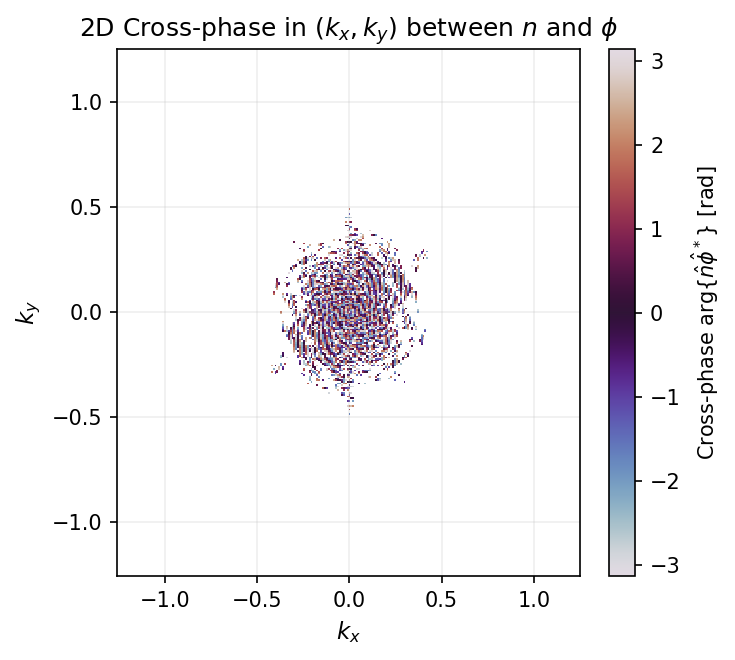

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) Pick one time slice from 3D fields
#    dens_fluct, strmf_fluct: (ny, nx, nt)
# ---------------------------------------------
it0 = -1  # last time, or any 0..nt-1
dens2d  = dens_fluct[:, :, it0]
phi2d   = strmf_fluct[:, :, it0]

ny, nx = dens2d.shape

# ---------------------------------------------
# 2) 2D FFT in (y,x) for both fields
# ---------------------------------------------
# Optional: subtract mean
dens2d_0 = dens2d - dens2d.mean()
phi2d_0  = phi2d  - phi2d.mean()

# Apply 2D FFT
N_k = np.fft.fft2(dens2d_0)
P_k = np.fft.fft2(phi2d_0)

# Shift zero-frequency to center
N_k = np.fft.fftshift(N_k)
P_k = np.fft.fftshift(P_k)

# ---------------------------------------------
# 3) Cross-spectrum and cross-phase in k-space
# ---------------------------------------------
S_nphi = N_k * np.conj(P_k)         # cross-spectrum
phase_k = np.angle(S_nphi)          # cross-phase in radians
amp_k   = np.abs(S_nphi)            # optional, for masking

# ---------------------------------------------
# 4) Build kx, ky arrays (in code units)
# ---------------------------------------------
dkx = 2.0 * np.pi / (nx * (s.x[1] - s.x[0]))
dky = 2.0 * np.pi / (ny * (s.y[1] - s.y[0]))

kx = np.fft.fftshift(np.fft.fftfreq(nx, d=s.x[1] - s.x[0])) * 2*np.pi
ky = np.fft.fftshift(np.fft.fftfreq(ny, d=s.y[1] - s.y[0])) * 2*np.pi

KX, KY = np.meshgrid(kx, ky)

# ---------------------------------------------
# 5) Plot 2D cross-phase map in (kx, ky)
# ---------------------------------------------
fig, ax = plt.subplots(figsize=(5, 4.5), dpi=150)

# Option: mask very small amplitudes to avoid noisy phase
amp_thresh = 0.01 * amp_k.max()
phase_plot = np.ma.masked_where(amp_k < amp_thresh, phase_k)

im = ax.pcolormesh(
    KX, KY, phase_plot,
    shading='auto',
    cmap='twilight'
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Cross-phase arg$\{ \hat{n}\hat{\phi}^* \}$ [rad]', fontsize=10)

ax.set_xlabel(r'$k_x$', fontsize=11)
ax.set_ylabel(r'$k_y$', fontsize=11)
ax.set_title(r'2D Cross-phase in $(k_x,k_y)$ between $n$ and $\phi$', fontsize=12)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


# Define function

In [5]:
import numpy as np

def cross_phase_time_series(a, b, dt):
    """
    Compute cross-phase and coherence between two real time series a(t), b(t).

    Parameters
    ----------
    a, b : 1D arrays
        Time series (same length).
    dt : float
        Time step.

    Returns
    -------
    freq : 1D array
        Frequencies (Hz or code units) of the FFT.
    phase : 1D array
        Cross-phase arg(S_ab) in radians.
    coherence : 1D array
        Magnitude-squared coherence |S_ab|^2 / (S_aa S_bb).
    """
    a = np.asarray(a)
    b = np.asarray(b)
    assert a.shape == b.shape, "a and b must have same shape"

    n = a.size

    # Remove mean
    a0 = a - a.mean()
    b0 = b - b.mean()

    # Optional window to reduce spectral leakage
    win = np.hanning(n)
    a_w = a0 * win
    b_w = b0 * win

    # FFT (one-sided)
    A = np.fft.rfft(a_w)
    B = np.fft.rfft(b_w)

    S_ab = A * np.conj(B)
    S_aa = np.abs(A)**2
    S_bb = np.abs(B)**2

    phase = np.angle(S_ab)
    coherence = np.abs(S_ab)**2 / (S_aa * S_bb + 1e-20)

    freq = np.fft.rfftfreq(n, dt)

    return freq, phase, coherence


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def cross_phase_kxky(dens_fluct, strmf_fluct, s, it=-1, amp_thresh_frac=0.01):
    """
    Cross-phase in (kx, ky) between density and potential at a given time index.

    dens_fluct, strmf_fluct : (ny, nx, nt)
    s.x, s.y                : coordinates
    it                      : time index (default last)
    amp_thresh_frac         : fraction of max amplitude for masking noisy phase
    """
    ny, nx, nt = dens_fluct.shape
    assert strmf_fluct.shape == dens_fluct.shape

    # Pick time slice
    n2d  = dens_fluct[:, :, it]
    phi2d = strmf_fluct[:, :, it]

    # Remove mean to avoid strong k=0 component
    n2d  = n2d  - n2d.mean()
    phi2d = phi2d - phi2d.mean()

    # 2D FFT in (y, x)
    N_k = np.fft.fft2(n2d)
    P_k = np.fft.fft2(phi2d)

    # Shift zero frequency to center
    N_k = np.fft.fftshift(N_k)
    P_k = np.fft.fftshift(P_k)

    # Cross-spectrum and phase
    S_nphi = N_k * np.conj(P_k)
    phase_k = np.angle(S_nphi)
    amp_k   = np.abs(S_nphi)

    # kx, ky arrays (code units)
    dx = float(s.x[1] - s.x[0])
    dy = float(s.y[1] - s.y[0])

    kx = np.fft.fftshift(np.fft.fftfreq(nx, d=dx)) * 2.0 * np.pi
    ky = np.fft.fftshift(np.fft.fftfreq(ny, d=dy)) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)

    # Mask low-amplitude modes to avoid noisy phases
    amp_thresh = amp_thresh_frac * amp_k.max()
    phase_plot = np.ma.masked_where(amp_k < amp_thresh, phase_k)

    # Plot
    fig, ax = plt.subplots(figsize=(5, 4.5), dpi=150)
    im = ax.pcolormesh(KX, KY, phase_plot, shading='auto', cmap='twilight')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r'Cross-phase $\arg\{\hat{n}\hat{\phi}^*\}$ [rad]', fontsize=10)

    ax.set_xlabel(r'$k_x$', fontsize=11)
    ax.set_ylabel(r'$k_y$', fontsize=11)
    ax.set_title(r'Cross-phase in $(k_x,k_y)$ between $n$ and $\phi$', fontsize=12)
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    return KX, KY, phase_k, amp_k

# Example usage:
# KX, KY, phase_k, amp_k = cross_phase_kxky(dens_fluct, strmf_fluct, s, it=-1)


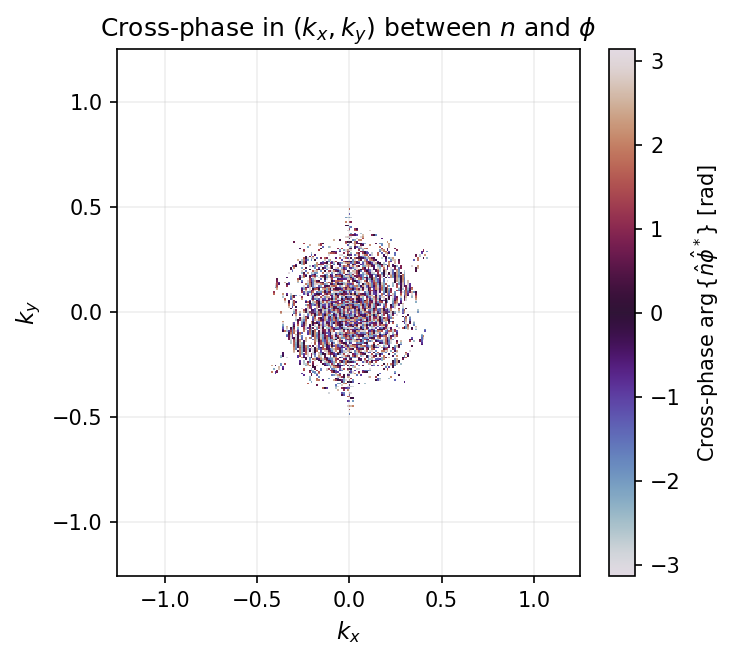

(array([[-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676],
        [-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676],
        [-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676],
        ...,
        [-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676],
        [-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676],
        [-1.25663706, -1.24633676, -1.23603645, ...,  1.22573615,
          1.23603645,  1.24633676]]),
 array([[-1.25663706, -1.25663706, -1.25663706, ..., -1.25663706,
         -1.25663706, -1.25663706],
        [-1.24888004, -1.24888004, -1.24888004, ..., -1.24888004,
         -1.24888004, -1.24888004],
        [-1.24112302, -1.24112302, -1.24112302, ..., -1.24112302,
         -1.24112302, -1.24112302],
        ...,
        [ 1.233366  ,  1.233366  ,  1.233366  , ...,  

In [11]:
cross_phase_kxky(dens_fluct, strmf_fluct, s, it=-1, amp_thresh_frac=0.01)

/tmp/ipykernel_3886184/1324391381.py:57: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(KY, OM, phase_plot, shading='auto', cmap='twilight')


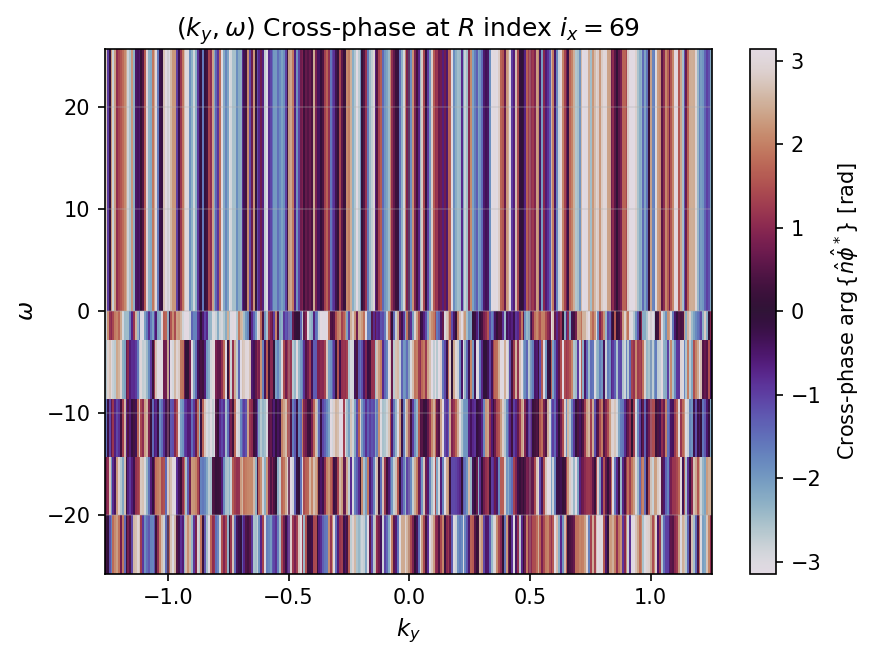

/tmp/ipykernel_3886184/1324391381.py:70: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax2.pcolormesh(KY, OM, coherence_kω, shading='auto', cmap='viridis')


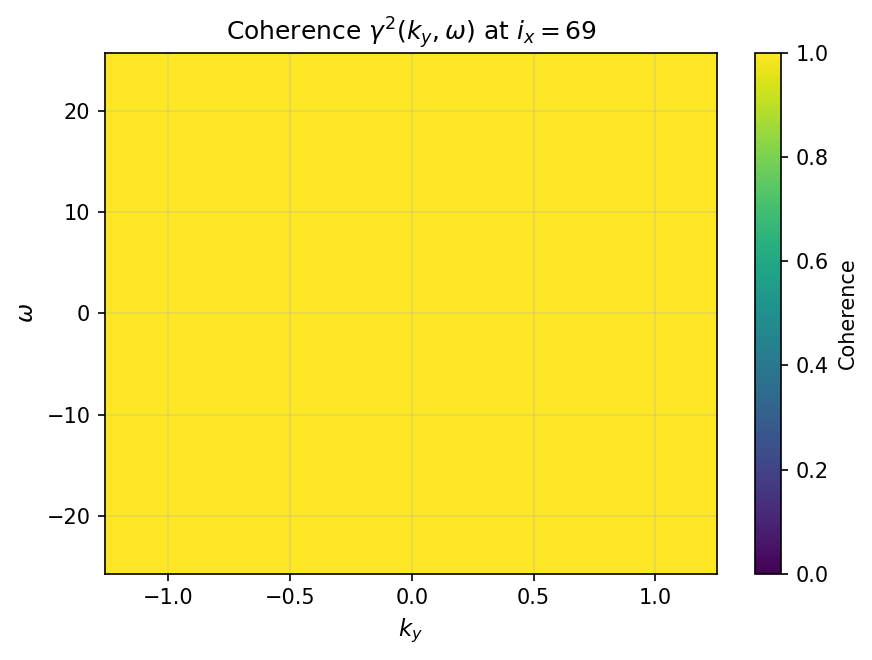

(array([[-1.25663706, -1.25663706, -1.25663706, ..., -1.25663706,
         -1.25663706, -1.25663706],
        [-1.24888004, -1.24888004, -1.24888004, ..., -1.24888004,
         -1.24888004, -1.24888004],
        [-1.24112302, -1.24112302, -1.24112302, ..., -1.24112302,
         -1.24112302, -1.24112302],
        ...,
        [ 1.233366  ,  1.233366  ,  1.233366  , ...,  1.233366  ,
          1.233366  ,  1.233366  ],
        [ 1.24112302,  1.24112302,  1.24112302, ...,  1.24112302,
          1.24112302,  1.24112302],
        [ 1.24888004,  1.24888004,  1.24888004, ...,  1.24888004,
          1.24888004,  1.24888004]]),
 array([[  0.       ,   5.7114155,  11.422831 , ..., -17.1342465,
         -11.422831 ,  -5.7114155],
        [  0.       ,   5.7114155,  11.422831 , ..., -17.1342465,
         -11.422831 ,  -5.7114155],
        [  0.       ,   5.7114155,  11.422831 , ..., -17.1342465,
         -11.422831 ,  -5.7114155],
        ...,
        [  0.       ,   5.7114155,  11.422831 , ..., -

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def cross_phase_map_at_freq(dens_fluct, strmf_fluct, s, f0, coh_min=0.0):
    """
    Real-space (R,Z) map of cross-phase at a given frequency f0.

    dens_fluct, strmf_fluct : (ny, nx, nt)
    s.time                  : time array
    f0                      : target frequency (in 1/time units of s.time)
    coh_min                 : minimum coherence to show (mask lower)
    """
    ny, nx, nt = dens_fluct.shape
    assert strmf_fluct.shape == dens_fluct.shape

    t_arr = np.asarray(s.time)
    dt = float(t_arr[1] - t_arr[0])

    # Remove time mean at each point
    n_yx_t   = dens_fluct - dens_fluct.mean(axis=2, keepdims=True)
    phi_yx_t = strmf_fluct - strmf_fluct.mean(axis=2, keepdims=True)

    # FFT over time (axis=2)
    N_f   = np.fft.rfft(n_yx_t, axis=2)      # (ny, nx, nf)
    Phi_f = np.fft.rfft(phi_yx_t, axis=2)    # (ny, nx, nf)

    freq = np.fft.rfftfreq(nt, d=dt)         # (nf,) in 1/time units

    # Find nearest frequency index
    ifreq = int(np.argmin(np.abs(freq - f0)))
    f_sel = freq[ifreq]
    print(f"Target f0={f0:.4g}, using nearest FFT freq f={f_sel:.4g}")

    # Cross-spectrum & coherence at that frequency
    S_nphi = N_f[:, :, ifreq] * np.conj(Phi_f[:, :, ifreq])   # (ny, nx)
    S_nn   = np.abs(N_f[:, :, ifreq])**2
    S_pp   = np.abs(Phi_f[:, :, ifreq])**2

    phase_map = np.angle(S_nphi)
    coherence_map = np.abs(S_nphi)**2 / (S_nn * S_pp + 1e-20)

    # Mask low coherence if requested
    if coh_min > 0.0:
        phase_plot = np.ma.masked_where(coherence_map < coh_min, phase_map)
    else:
        phase_plot = phase_map

    # Real-space plot
    X, Y = np.meshgrid(s.x, s.y)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    im = ax.pcolormesh(X, Y, phase_plot, shading='auto', cmap='twilight')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r'Cross-phase at $f \approx f_0$ [rad]', fontsize=10)

    ax.set_xlabel(r'$R$', fontsize=11)
    ax.set_ylabel(r'$Z$', fontsize=11)
    ax.set_title(fr'Cross-phase map at $f_0={f_sel:.3g}$', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Optional: add separatrix
    # ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=1.0)

    plt.tight_layout()
    plt.show()

    # Coherence map (optional)
    fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=150)
    im2 = ax2.pcolormesh(X, Y, coherence_map, shading='auto', cmap='viridis')
    cbar2 = fig2.colorbar(im2, ax=ax2)
    cbar2.set_label(r'Coherence at $f \approx f_0$', fontsize=10)
    ax2.set_xlabel(r'$R$', fontsize=11)
    ax2.set_ylabel(r'$Z$', fontsize=11)
    ax2.set_title(fr'Coherence map at $f_0={f_sel:.3g}$', fontsize=12)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return phase_map, coherence_map, freq

# Example usage:
# Pick f0 near dominant fluctuation frequency, e.g. f0 = 0.01
# phase_map, coh_map, freq = cross_phase_map_at_freq(dens_fluct, strmf_fluct, s, f0=0.01, coh_min=0.2)
